In [1]:
from behavior_python.detection.wheelDetectionSession import WheelDetectionSession
from behavior_python.plotters.basePlotters import *
from behavior_python.plotters.detection.wheelDetectionSessionPlotter import *
from behavior_python.plotters.detection.wheelDetectionTrialPlotter import DetectionTrialPlotter

import glob
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import scipy.interpolate as interpolate

from behavior_python.wheelUtils import *

In [7]:
animalid = 'KC144'
area = '*'
glob.glob(f'J:\\presentation\\*_{animalid}_detect_opto*_{area}*')

['J:\\presentation\\230112_KC144_detect_opto120_dorsal__no_cam_KC',
 'J:\\presentation\\230117_KC144_detect_opto120_AL__no_cam_KC',
 'J:\\presentation\\230119_KC144_detect_opto120_ventralPM__no_cam_KC',
 'J:\\presentation\\230124_KC144_detect_opto120_AL__no_cam_KC',
 'J:\\presentation\\230208_KC144_detect_opto120_PM__no_cam_KC',
 'J:\\presentation\\230211_KC144_detect_opto120_RL__no_cam_KC',
 'J:\\presentation\\230215_KC144_detect_opto120_LMPM__no_cam_KC',
 'J:\\presentation\\230216_KC144_detect_opto120_LM__no_cam_KC',
 'J:\\presentation\\230221_KC144_detect_opto120_AM__no_cam_KC',
 'J:\\presentation\\230228_KC144_detect_opto120_HVA__no_cam_KC',
 'J:\\presentation\\230302_KC144_detect_opto120_V1__no_cam_KC',
 'J:\\presentation\\230316_KC144_detect_opto120_LM__no_cam_KC',
 'J:\\presentation\\230322_KC144_detect_opto120_AL__no_cam_KC',
 'J:\\presentation\\230324_KC144_detect_opto120_PM__no_cam_KC',
 'J:\\presentation\\230328_KC144_detect_opto120_PM__no_cam_KC',
 'J:\\presentation\\230405

In [9]:
exp_name = '230907_KC144_detect_opto120_dorsalipsi__no_cam_KC'
w = WheelDetectionSession(exp_name,load_flag=False)
# setting outcome
# w.data.set_outcome('state') # can also be 'wheel' for wheel reaction outcome classification
w.stats

[23-10-19 20:51:18] - Found session rawdata at J:\presentation
[23-10-19 20:51:18] -  : Started analysis of 230907_KC144_detect_opto120_dorsalipsi__no_cam_KC
[23-10-19 20:51:18] -  : Found saved data: J:\analysis\230907_KC144_detect_opto120_dorsalipsi__no_cam_KC\sessionData.parquet
[23-10-19 20:51:39] - Access granted to Mouse Database_new
[23-10-19 20:51:42] - Parsing stimlog...


Reading logs : 100%|██████████| 2/2 [00:00<00:00, 142.35it/s]


[23-10-19 20:51:42] - Parsing riglog...


Reading logs : 100%|██████████| 13/13 [00:00<00:00, 1623.57it/s]

[23-10-19 20:51:43] - No data found for log key(s) : ['imaging', 'button', 'lap', 'cam1', 'cam2', 'act0', 'act1']
The number of screen pulses 827 does not match the visual stimulation photo:828 log.
[23-10-19 20:51:43] - Read data : 1.16s



Extracting trial data:: 100%|██████████| 743/743 [00:17<00:00, 42.55it/s]


[23-10-19 20:52:01] - Setting outcome to state
[23-10-19 20:52:02] - Saved session data
[23-10-19 20:52:02] - Saving... : 1.52s
[23-10-19 20:52:02] - SESSION : Saving data to J:\analysis\230907_KC144_detect_opto120_dorsalipsi__no_cam_KC
[23-10-19 20:52:02] - SESSION : Done! t=44.13 s


all_count = 743
early_count = 354
stim_count = 389
correct_count = 258
miss_count = 131
all_correct_percent = 34.724
hit_rate = 66.324
easy_hit_rate = 88.439
false_alarm = 57.843
nogo_percent = 33.676
median_response_time = 282.0
d_prime = 0.22344329439806154

In [10]:
# make a matrix ntrials X nfeatures
ntrials = len(w.data.data)
nfeatures = 5000

time_window = [-1000,1000] # range to get the wheel trace


pca_matrix = np.zeros((ntrials,nfeatures),dtype=float)
state_outcome_vector = np.zeros((ntrials,1))
wheel_outcome_vector = np.zeros((ntrials,1))

for i,row in enumerate(w.data.data.iter_rows(named=True)):
    wheel_time = np.array(row['wheel_time'])
    wheel_pos = np.array(row['wheel_pos'])
    
    mask = np.where((time_window[0]<wheel_time) & (wheel_time<time_window[1]))    
    if len(mask[0]):
        wheel_time = wheel_time[mask]
        wheel_pos = wheel_pos[mask]
        try:
            t = np.linspace(wheel_time[0], wheel_time[-1],nfeatures)
        except:
            print('kk')
        pos = interpolate.interp1d(wheel_time, wheel_pos, kind='linear')(t)
    else:
        pos = np.array([0]*nfeatures,dtype=float)
    
    state_outcome_vector[i] = row['state_outcome']
    wheel_outcome_vector[i] = row['wheel_outcome']
    pca_matrix[i,:] = pos

In [11]:
# standardize the traces
pca_x = StandardScaler().fit_transform(pca_matrix)

In [12]:
pca = PCA(n_components=2)
pc = pca.fit_transform(pca_x)

# map PCA range
# interp1d([-1,1],[5,10])

Text(0.5, 0.98, 'Position PCA for wheel traces between [-1000, 1000]\n230907_KC144_detect_opto120_dorsalipsi__no_cam_KC')

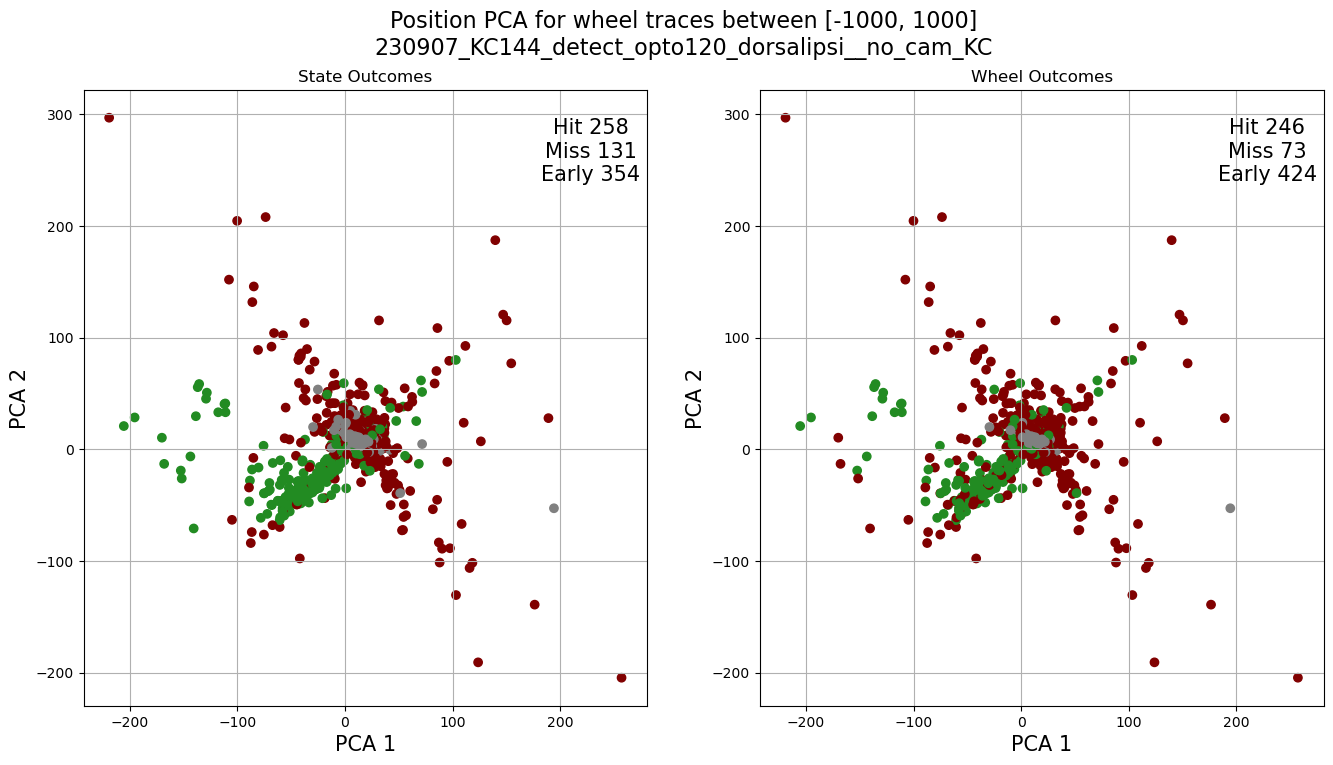

In [13]:
fig = plt.figure(figsize = (16,8))
ax1 = fig.add_subplot(1,2,1) 

color_dict = {-1:'maroon',
              0:'gray',
              1:'forestgreen'}

colors1 = [color_dict[i[0]] for i in state_outcome_vector]

ax1.scatter(pc[:,0],pc[:,1],c=colors1)

ax1.text(0.9,0.9,
         f"Hit {len(state_outcome_vector[state_outcome_vector==1])}\nMiss {len(state_outcome_vector[state_outcome_vector==0])}\nEarly {len(state_outcome_vector[state_outcome_vector==-1])}",
         fontsize=15,
         horizontalalignment='center',
        verticalalignment='center', transform=ax1.transAxes)
ax1.grid()

ax1.set_title('State Outcomes')
ax1.set_xlabel('PCA 1', fontsize = 15)
ax1.set_ylabel('PCA 2', fontsize = 15)


ax2 = fig.add_subplot(1,2,2) 
colors2 = [color_dict[i[0]] for i in wheel_outcome_vector]

ax2.scatter(pc[:,0],pc[:,1],c=colors2)

ax2.text(0.9,0.9,
         f"Hit {len(wheel_outcome_vector[wheel_outcome_vector==1])}\nMiss {len(wheel_outcome_vector[wheel_outcome_vector==0])}\nEarly {len(wheel_outcome_vector[wheel_outcome_vector==-1])}",
         fontsize=15,
          horizontalalignment='center',
        verticalalignment='center', transform=ax2.transAxes)

ax2.grid()
ax2.set_title('Wheel Outcomes')
ax2.set_xlabel('PCA 1', fontsize = 15)
ax2.set_ylabel('PCA 2', fontsize = 15)

fig.suptitle(f'Position PCA for wheel traces between {time_window}\n{exp_name}', fontsize=16)